In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load in data**

In [2]:
all_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_ecd", "gcs_mn_se_ecd", "tot_asmt_ecd",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
    "gcs_mn_mfg", "gcs_mn_se_mfg", "tot_asmt_mfg",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
    "gcs_mn_nec", "gcs_mn_se_nec", "tot_asmt_nec",
    "gcs_mn_neg", "gcs_mn_se_neg", "tot_asmt_neg",
    "gcs_mn_wag", "gcs_mn_se_wag", "tot_asmt_wag",
    "gcs_mn_wbg", "gcs_mn_se_wbg", "tot_asmt_wbg",
    "gcs_mn_whg", "gcs_mn_se_whg", "tot_asmt_whg",
    "gcs_mn_wht", "gcs_mn_se_wht", "tot_asmt_wht",
    "gcs_mn_wng", "gcs_mn_se_wng", "tot_asmt_wng",
]

race_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_asn", "gcs_mn_se_asn", "tot_asmt_asn",
    "gcs_mn_blk", "gcs_mn_se_blk", "tot_asmt_blk",
    "gcs_mn_hsp", "gcs_mn_se_hsp", "tot_asmt_hsp",
    "gcs_mn_nam", "gcs_mn_se_nam", "tot_asmt_nam",
]

gender_cols = [
    "gcs_mn_all", "gcs_mn_se_all", "tot_asmt_all",
    "gcs_mn_fem", "gcs_mn_se_fem", "tot_asmt_fem",
    "gcs_mn_mal", "gcs_mn_se_mal", "tot_asmt_mal",
]

In [ ]:
if not os.path.exists("./data/data.db"):
    os.system("python build_db.py")

conn = sqlite3.connect("./data/data.db")
c = conn.cursor()


COLS_EXCLUDE = set([
    "StateAbbr",
    "StateDesc",
    "CountyName",
    "CountyFIPS",
    "TractFIPS",
    "fips",
    "stateabb",
    "sedaadmin",
    "sedaadminname",
    "TRACT",
    "COUNT"
])

c.execute(f"""
WITH seda_tracts AS (
    SELECT *
    FROM seda s
    JOIN nces n
    ON s.sedaadmin = n.LEAID
    WHERE s.year = 2019
)

, food_atlas_tracts AS (
    SELECT *
    FROM food f
    JOIN seda_tracts st
    ON st.TRACT = f.CensusTract
)

, cdc_tracts AS (
    SELECT *
    FROM cdc c
    JOIN food_atlas_tracts ft
    ON ft.TRACT = c.TractFIPS
)

SELECT *
FROM cdc_tracts;
""")

rows = c.fetchall()
print(len(rows))
columns = [col[0] for col in c.description]

## Write the rows manually into a CSV file without pandas
with open("data/full_joined_table.csv", "w") as f:
    to_exclude = set()
    # race_cols = []
    # for i, col in enumerate(columns):
    #     if (col.startswith("gcs") or col.startswith("tot")) and col not in race_cols:
    #         to_exclude.add(i)

    f.write(",".join(columns) + "\n")
    for row in tqdm(rows):
        f.write(",".join([str(x) for i, x in enumerate(row) if i not in to_exclude]) + "\n")


995894


100%|██████████| 995894/995894 [00:15<00:00, 62604.23it/s]


In [ ]:
df = pd.read_csv("data/full_joined_table.csv")
df

KeyboardInterrupt: 

           area_type  avg_score  num_entries
0    Non–Food Desert   5.371345       841300
1  Rural Food Desert   4.488983        11748
2  Urban Food Desert   4.490533       142810


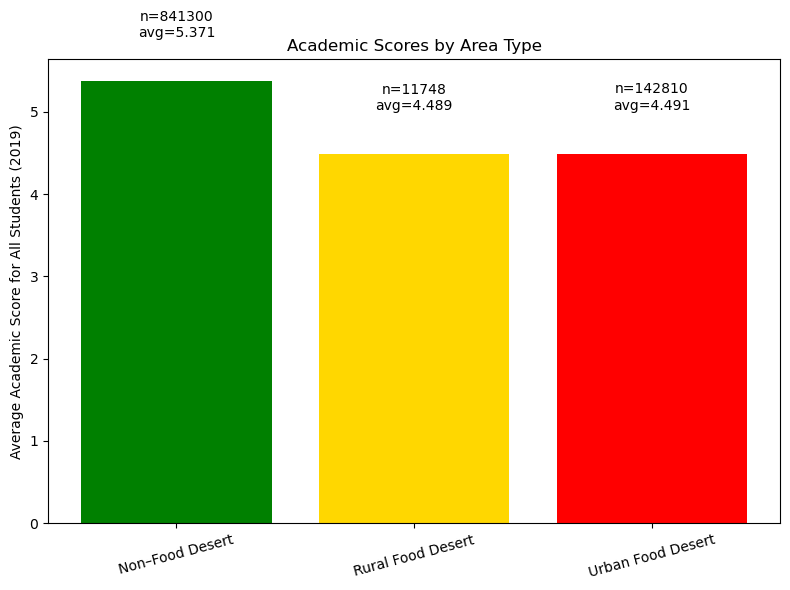

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("data/full_joined_table.csv")

# Drop missing values 
df = df.dropna(subset=['gcs_mn_all', 'PovertyRate'])

# Define food desert conditions
poverty = df['PovertyRate'] > 20
low_income = df['LowIncomeTracts'] == 1
urban_fd = (df['Urban'] == 1) & (df['LATracts_half'] == 1)
rural_fd = (df['Urban'] == 0) & (df['LATracts10'] == 1)

# Create area_type column
df['area_type'] = 'Non–Food Desert'
df.loc[poverty & low_income & urban_fd, 'area_type'] = 'Urban Food Desert'
df.loc[poverty & low_income & rural_fd, 'area_type'] = 'Rural Food Desert'

# Group by area type and compute mean and count
score_summary = df.groupby('area_type')['gcs_mn_all'].agg(['mean', 'count']).reset_index()
score_summary.columns = ['area_type', 'avg_score', 'num_entries']
print(score_summary)

# Define custom colors
color_map = {
    'Urban Food Desert': 'red',
    'Rural Food Desert': 'gold',
    'Non–Food Desert': 'green'
}
bar_colors = [color_map[area] for area in score_summary['area_type']]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(
    score_summary['area_type'],
    score_summary['avg_score'],
    color=bar_colors
)

# Add count labels on top of each bar
for bar, count, avg in zip(bars, score_summary['num_entries'], score_summary['avg_score']):
    height = bar.get_height()
    label = f'n={count}\navg={avg:.3f}'
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, label, ha='center', va='bottom')

# Labels and title
plt.ylabel('Average Academic Score for All Students (2019)')
plt.title('Academic Scores by Area Type')
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()